In [1]:
import numpy as np
import pandas as pd
import imblearn
from datetime import datetime as dt
from datetime import date
import IPython
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer, StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
import xgboost as xgb
sns.set()
import warnings
pd.options.display.max_rows = 260
warnings.filterwarnings("ignore")

# IMPORTING DATAS

In [2]:
df_train = pd.read_csv("/kaggle/input/migros-datathon-coderspace/train.csv")
df_test = pd.read_csv("/kaggle/input/migros-datathon-coderspace/test.csv")
ID = df_test["individualnumber"]

In [3]:
df_transaction_sale = pd.read_csv("/kaggle/input/migros-datathon-coderspace/transaction_sale/transaction_sale.csv")
df_customer = pd.read_csv("/kaggle/input/migros-datathon-coderspace/customer.csv")
df_customeraccount = pd.read_csv("/kaggle/input/migros-datathon-coderspace/customeraccount.csv")
df_categories = pd.read_csv("/kaggle/input/migros-datathon-coderspace/genel_kategoriler.csv")
df_sample_submission = pd.read_csv("/kaggle/input/migros-datathon-coderspace/sample_submission.csv")
df_transaction_header = pd.read_csv("/kaggle/input/migros-datathon-coderspace/transaction_header.csv")
df_product_groups = pd.read_csv("/kaggle/input/migros-datathon-coderspace/product_groups.csv")

In [4]:
# Outlier Function
def outlier_treat( df:pd.DataFrame, col: str, limit=0.01 ) -> pd.DataFrame:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    low_limit = len(df[df[col] < lower_bound]) / len(df[col])
    up_limit = len(df[df[col] < lower_bound]) / len(df[col])

    if up_limit < limit:
        df = df[df[col] <= upper_bound]
    if low_limit < limit:
        df = df[df[col] >= lower_bound]
    return df

# UNIQUE VALUES

In [5]:
df_trans_cust = df_customeraccount.merge(df_transaction_header, on="cardnumber", how="left")
q_card = df_trans_cust["cardnumber"].nunique()
q_cust = df_trans_cust["individualnumber"].nunique()
q_basket = df_trans_cust["basketid"].nunique()
print("q_card : {}, q_cust : {}, q_basket : {}".format(q_card, q_cust, q_basket))

q_card : 35159, q_cust : 28593, q_basket : 1089180


In [6]:
df_product_groups

,category_number,category_level_1,category_level_2,category_level_3,category_level_4
0,9046,341,20,10,10
1,9009,125,25,10,10
2,9049,410,65,20,10
3,9019,300,10,19,11
4,9035,305,31,10,10
...,...,...,...,...,...
3908,9019,616,95,20,15
3909,9020,616,95,20,10
3910,9020,616,95,20,15
3911,9020,616,95,20,30


# MERGING THE WHOLE DATA

In [7]:
df_merged = df_transaction_sale.merge(df_transaction_header, on="basketid", how="left")
df_merged = df_merged.merge(df_customeraccount,on='cardnumber',how='left')
df_merged = df_merged[df_merged["quantity"] > 0]
df_return = df_merged[df_merged["amount"] < 0]
df_free = df_merged[df_merged["amount"] == 0]
df_merged = df_merged[df_merged["amount"] > 0]
df_merged["monetary"] = df_merged["amount"]

In [8]:
df_free.head(10)

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,date_of_transaction,cardnumber,is_sanal,individualnumber
1187,20123007100317097,613,15,15,25,0.0,1.0,NaN,0.00,4.25,2020-12-30,1787874694567415,1,93677638
1273,20121607010033343,103,35,10,10,0.0,1.0,NaN,0.00,1.25,2020-12-16,9787874699563015,0,99920645
1456,20123007680013378,613,15,15,25,0.0,1.0,NaN,0.00,4.25,2020-12-30,8287994613560515,0,95018448
1702,20121602980137453,618,15,45,10,0.0,1.0,NaN,0.00,15.65,2020-12-16,7387964668568115,0,100102682
1703,20121602980137453,103,35,10,10,0.0,1.0,NaN,0.00,1.25,2020-12-16,7387964668568115,0,100102682
2067,20121507340049637,103,35,10,10,0.0,1.0,NaN,0.00,1.25,2020-12-15,5987784637561615,0,95337210
2322,20122402920027661,103,35,10,10,0.0,1.0,NaN,0.00,1.25,2020-12-24,187734640564015,0,91741065
2634,20122503830067161,200,25,30,10,0.0,1.0,NaN,2.25,8.50,2020-12-25,2587784615560518,0,21347972
2635,20122503830067161,103,35,10,10,0.0,1.0,NaN,0.00,1.25,2020-12-25,2587784615560518,0,21347972
2679,20122504500039298,103,35,10,10,0.0,1.0,NaN,0.00,1.25,2020-12-25,6787664643569015,0,91741400


In [9]:
df_return.head(10)

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,date_of_transaction,cardnumber,is_sanal,individualnumber
243306,21011518340021003,305,20,11,10,-0.01,0.94,0.010000,0.0,2.59,2021-01-15,1605662454374926,0,84711155
260869,21011622940017302,305,20,11,10,-0.01,1.14,-0.000501,0.0,3.14,2021-01-16,7587974689569115,0,89086894
271167,21011527350040730,305,20,11,12,-0.01,0.98,0.010000,0.0,1.72,2021-01-15,3087554617560532,0,21035314
309753,21011937460025874,305,20,11,10,-0.01,1.14,NaN,0.0,3.14,2021-01-19,6087654677561615,0,94787504
2682321,21011839300021898,305,20,11,10,-0.01,0.70,NaN,0.0,1.93,2021-01-18,9287804608563915,0,13159404
3243242,21011659880019070,305,20,11,10,-0.01,0.98,-0.000400,0.0,2.70,2021-01-16,3787634660564215,0,96242926
4277409,21011548560028945,305,20,11,10,-0.01,0.98,NaN,0.0,2.70,2021-01-15,2105392433247917,0,7403958
4774705,21011502920014252,305,20,11,12,-0.01,1.10,0.010000,0.0,2.15,2021-01-15,187734640564015,0,91741065
5130370,21012156320037129,305,20,11,10,-0.01,0.94,NaN,0.0,2.59,2021-01-21,7787884606568715,0,83853991
5164897,21011755310159902,305,20,11,10,-0.01,1.46,-0.000512,0.0,4.02,2021-01-17,4587054607567015,0,91707889


# DATE FEATURE

In [10]:
df_merged["shop_days"] = pd.to_datetime(df_merged["date_of_transaction"])
df_merged["shop_days"] = pd.Timestamp.now() - df_merged["shop_days"]
df_merged["shop_days"] = df_merged["shop_days"].dt.days
df_merged["shop_days"] = df_merged["shop_days"] - df_merged["shop_days"].min()

In [11]:
df_cat1 = df_merged[['individualnumber', 'category_level_1']].groupby(['individualnumber'], as_index=False).sum().sort_values(by='category_level_1', ascending = False)
df_cat1['category_level_1'] = df_cat1['category_level_1'].fillna(df_cat1['category_level_1'].median())
df_cat2 = df_merged[['individualnumber', 'category_level_2']].groupby(['individualnumber'], as_index=False).sum().sort_values(by='category_level_2', ascending = False)
df_cat2['category_level_2'] = df_cat2['category_level_2'].fillna(df_cat2['category_level_2'].median())
df_cat3 = df_merged[['individualnumber', 'category_level_3']].groupby(['individualnumber'], as_index=False).sum().sort_values(by='category_level_3', ascending = False)
df_cat3['category_level_3'] = df_cat3['category_level_3'].fillna(df_cat3['category_level_3'].median())
df_cat4 = df_merged[['individualnumber', 'category_level_4']].groupby(['individualnumber'], as_index=False).sum().sort_values(by='category_level_4', ascending = False)
df_cat4['category_level_4'] = df_cat4['category_level_4'].fillna(df_cat4['category_level_4'].median())

In [12]:
df_merged["category_code"] = df_merged["category_level_1"].astype(str)+df_merged["category_level_2"].astype(str)+df_merged["category_level_3"].astype(str)+df_merged["category_level_4"].astype(str)

In [13]:
df_merged.head(20)

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,date_of_transaction,cardnumber,is_sanal,individualnumber,monetary,shop_days,category_code
0,20120706070177471,613,50,50,15,19.90,2.000,NaN,0.0,0.0,2020-12-07,6187974647569015,0,90065509,19.90,359,613505015
1,20120706070177471,425,30,12,10,3.50,1.000,NaN,0.0,0.0,2020-12-07,6187974647569015,0,90065509,3.50,359,425301210
2,20120706070177471,425,30,12,11,7.90,1.000,NaN,0.0,0.0,2020-12-07,6187974647569015,0,90065509,7.90,359,425301211
3,20122703940031323,103,25,15,10,7.90,2.000,NaN,0.0,0.0,2020-12-27,3587114684567715,0,56076820,7.90,339,103251510
4,20122703940031323,101,15,15,15,16.00,1.000,NaN,0.0,0.0,2020-12-27,3587114684567715,0,56076820,16.00,339,101151515
5,20122703940031323,103,25,15,10,3.95,1.000,NaN,0.0,0.0,2020-12-27,3587114684567715,0,56076820,3.95,339,103251510
6,20122703940031323,410,30,10,1,4.90,1.000,NaN,0.0,0.0,2020-12-27,3587114684567715,0,56076820,4.90,339,41030101
7,20122703940031323,505,60,10,10,1.50,1.000,NaN,0.0,0.0,2020-12-27,3587114684567715,0,56076820,1.50,339,505601010
8,20122904500030281,340,30,10,10,15.08,0.222,1.883431,0.0,0.0,2020-12-29,3487194607560416,0,37752547,15.08,337,340301010
9,20122904500030281,131,25,20,10,10.00,1.000,1.248959,0.0,0.0,2020-12-29,3487194607560416,0,37752547,10.00,337,131252010


In [14]:
df_merged[df_merged["discount_type_1"]>100].head(20)

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,date_of_transaction,cardnumber,is_sanal,individualnumber,monetary,shop_days,category_code
5908,20122904800089122,430,50,10,18,399.90,1.000,191.257700,0.00,0.00,2020-12-29,2687794681565015,0,92626472,399.90,337,430501018
10033,20123006070397268,430,50,10,36,228.68,1.000,112.000000,0.00,76.22,2020-12-30,3687594682568115,1,92989611,228.68,336,430501036
31249,20120717700033979,340,10,20,10,208.86,5.228,100.640850,52.28,0.00,2020-12-07,9987594696569515,0,93799578,208.86,359,340102010
45066,20122130050094005,210,10,20,30,276.00,24.000,203.285310,0.00,0.00,2020-12-21,2705222401376678,1,40532054,276.00,345,210102030
49662,20122930340036551,100,40,10,10,599.80,2.000,449.420700,0.00,0.00,2020-12-29,2787364635560515,0,3895560,599.80,337,100401010
59615,20122129870018389,340,20,20,11,134.81,2.108,123.224420,0.00,0.00,2020-12-21,8387864603569915,0,91387517,134.81,345,340202011
64877,20121430050048400,657,50,70,15,167.88,4.000,107.193940,0.00,111.92,2020-12-14,2587674666563315,0,95622650,167.88,352,657507015
64879,20121430050048400,410,50,70,23,419.85,5.000,268.080630,0.00,279.90,2020-12-14,2587674666563315,0,95622650,419.85,352,410507023
64883,20121430050048400,131,15,15,10,199.20,8.000,127.192240,0.00,0.00,2020-12-14,2587674666563315,0,95622650,199.20,352,131151510
68863,20120230440040170,101,15,15,15,102.00,6.000,101.990000,0.00,0.00,2020-12-02,6587414624565919,0,99201000,102.00,364,101151515


In [15]:
df_merged[df_merged["discount_type_1"] > df_merged["amount"]]

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,date_of_transaction,cardnumber,is_sanal,individualnumber,monetary,shop_days,category_code
10430,20121002550030076,618,10,10,25,4.15,1.000,4.152459,0.0,0.0,2020-12-10,2487914639565715,0,89360490,4.15,356,618101025
10431,20121002550030076,330,10,15,15,9.25,1.000,9.255480,0.0,0.0,2020-12-10,2487914639565715,0,89360490,9.25,356,330101515
10432,20121002550030076,313,30,10,10,9.45,1.000,9.455598,0.0,0.0,2020-12-10,2487914639565715,0,89360490,9.45,356,313301010
10433,20121002550030076,130,70,10,15,12.95,1.000,12.957672,2.3,2.3,2020-12-10,2487914639565715,0,89360490,12.95,356,130701015
10434,20121002550030076,335,50,10,15,26.98,2.006,26.995983,0.0,0.0,2020-12-10,2487914639565715,0,89360490,26.98,356,335501015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6332095,21011230270012892,617,15,15,50,21.20,1.000,21.949562,0.0,0.0,2021-01-12,3687764689568515,0,20574858,21.20,323,617151550
6332096,21011230270012892,305,20,13,11,3.33,1.128,3.447738,0.0,0.0,2021-01-12,3687764689568515,0,20574858,3.33,323,305201311
6332098,21011230270012892,305,20,10,14,5.33,0.895,5.518451,0.0,0.0,2021-01-12,3687764689568515,0,20574858,5.33,323,305201014
6332099,21011230270012892,425,10,15,10,27.90,1.000,28.886454,0.0,0.0,2021-01-12,3687764689568515,0,20574858,27.90,323,425101510


In [16]:
df_basket = df_merged.groupby(['individualnumber']).count()['basketid'].reset_index().sort_values(by='basketid', ascending = False)

In [17]:
df_shop = df_merged[['individualnumber', 'category_code']].groupby(['individualnumber'], as_index=False).count()

In [18]:
df_sanal = df_merged[['individualnumber', 'is_sanal']].groupby(['individualnumber'], as_index=False).sum()

In [19]:
df_total = df_shop.merge(df_sanal, on="individualnumber", how="left")
df_total.rename(columns = {'category_code':'market'}, inplace = True)
df_total["market"] = df_total["market"] - df_total["is_sanal"]

# NEW FEATURES

In [20]:
# Number of cards each customer have
df_card_q = df_customeraccount[['individualnumber', 'cardnumber']].groupby(['individualnumber'], as_index=False).count().sort_values(by='cardnumber', ascending = False)

In [21]:
df_merged['discount_type_1'].fillna(0.00001,inplace=True)
df_merged['discount_type_2'].fillna(df_merged['discount_type_2'].median(),inplace=True)
df_merged['discount_type_3'].fillna(df_merged['discount_type_3'].median(),inplace=True)

In [22]:
"""df_merged['discount_type_1']=np.where(df_merged['discount_type_1']>90,90,
                                       df_merged['discount_type_1'])
df_merged['discount_type_2']=np.where(df_merged['discount_type_2']>90,90,
                                       df_merged['discount_type_2'])
df_merged['discount_type_3']=np.where(df_merged['discount_type_3']>90,90,
                                       df_merged['discount_type_3'])"""

df_merged['overall_discount']=df_merged['discount_type_1']+df_merged['discount_type_2']+df_merged['discount_type_3']

In [23]:
df_dis = df_merged[['individualnumber', 'overall_discount']].groupby(['individualnumber'], as_index=False).sum()

In [24]:
df_code = df_merged.groupby(['individualnumber']).count()['category_code'].reset_index().sort_values(by='category_code', ascending = False)
df_code

,individualnumber,category_code
4883,89502680,7795
1439,20618034,6182
17776,97648448,5330
6135,92626472,5107
2839,62032387,5100
...,...,...
7470,93260183,1
20552,98882657,1
15484,96608929,1
20592,98898771,1


In [25]:
df_merged["total_price"] = df_merged["discount_type_3"]+df_merged["discount_type_2"]+df_merged["discount_type_1"]+df_merged["amount"]
df_merged["discount_per3"] = df_merged["discount_type_3"] / (df_merged["total_price"])
df_merged["discount_per2"] = (df_merged["discount_type_2"]) / (df_merged["total_price"])
df_merged["discount_per1"] = df_merged["discount_type_1"] / (df_merged["total_price"])
df_merged["discount_total"] = df_merged["discount_per1"]+df_merged["discount_per2"]+df_merged["discount_per3"]

In [26]:
df_dis_t = df_merged[['individualnumber', 'discount_total']].groupby(['individualnumber'], as_index=False).sum()
df_dis_1 = df_merged[['individualnumber', 'discount_per1']].groupby(['individualnumber'], as_index=False).sum()
df_dis_2 = df_merged[['individualnumber', 'discount_per2']].groupby(['individualnumber'], as_index=False).sum()
df_dis_3 = df_merged[['individualnumber', 'discount_per3']].groupby(['individualnumber'], as_index=False).sum()

In [27]:
df_code = df_merged.groupby(['category_code', "individualnumber"]).sum()['total_price'].reset_index().sort_values(by='total_price', ascending = False)
df_code

,category_code,individualnumber,total_price
1912555,430101310,94406899,65382.000100
17629,100401010,66725718,44959.775231
984410,210201513,65873755,36200.219968
1275710,305201012,18689432,35755.909528
2305404,705101010,98124217,33050.500060
...,...,...,...
2308689,706252010,79721301,0.010000
2308861,706252010,95449904,0.010000
2308862,706252010,95469292,0.010000
2308685,706252010,78280721,0.010000


In [28]:
df_merged.head(20)

,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,...,individualnumber,monetary,shop_days,category_code,overall_discount,total_price,discount_per3,discount_per2,discount_per1,discount_total
0,20120706070177471,613,50,50,15,19.90,2.000,0.000010,0.0,0.0,...,90065509,19.90,359,613505015,0.000010,19.900010,0.000000,0.0,5.025123e-07,5.025123e-07
1,20120706070177471,425,30,12,10,3.50,1.000,0.000010,0.0,0.0,...,90065509,3.50,359,425301210,0.000010,3.500010,0.000000,0.0,2.857135e-06,2.857135e-06
2,20120706070177471,425,30,12,11,7.90,1.000,0.000010,0.0,0.0,...,90065509,7.90,359,425301211,0.000010,7.900010,0.000000,0.0,1.265821e-06,1.265821e-06
3,20122703940031323,103,25,15,10,7.90,2.000,0.000010,0.0,0.0,...,56076820,7.90,339,103251510,0.000010,7.900010,0.000000,0.0,1.265821e-06,1.265821e-06
4,20122703940031323,101,15,15,15,16.00,1.000,0.000010,0.0,0.0,...,56076820,16.00,339,101151515,0.000010,16.000010,0.000000,0.0,6.249996e-07,6.249996e-07
5,20122703940031323,103,25,15,10,3.95,1.000,0.000010,0.0,0.0,...,56076820,3.95,339,103251510,0.000010,3.950010,0.000000,0.0,2.531639e-06,2.531639e-06
6,20122703940031323,410,30,10,1,4.90,1.000,0.000010,0.0,0.0,...,56076820,4.90,339,41030101,0.000010,4.900010,0.000000,0.0,2.040812e-06,2.040812e-06
7,20122703940031323,505,60,10,10,1.50,1.000,0.000010,0.0,0.0,...,56076820,1.50,339,505601010,0.000010,1.500010,0.000000,0.0,6.666622e-06,6.666622e-06
8,20122904500030281,340,30,10,10,15.08,0.222,1.883431,0.0,0.0,...,37752547,15.08,337,340301010,1.883431,16.963431,0.000000,0.0,1.110289e-01,1.110289e-01
9,20122904500030281,131,25,20,10,10.00,1.000,1.248959,0.0,0.0,...,37752547,10.00,337,131252010,1.248959,11.248959,0.000000,0.0,1.110289e-01,1.110289e-01


# RFM ANALYSIS

In [29]:
df_mon = df_merged[['individualnumber', 'monetary']].groupby(['individualnumber'], as_index=False).sum()
df_freq = df_merged[['individualnumber', 'basketid']].groupby(['individualnumber'], as_index=False).count()
df_rec = df_merged[['individualnumber', 'shop_days']].groupby(['individualnumber'], as_index=False).min()
df_per = df_merged.groupby('individualnumber').agg({'shop_days': ['min', 'max', "count"]}).reset_index()

df_freq["period"] = (df_per["shop_days"]["max"]-df_per["shop_days"]["min"])/df_per["shop_days"]["count"]
df_rec.loc[df_rec["shop_days"] > 70, "shop_days"] = 70
df_mon["monetary"] = np.log(df_mon["monetary"])
df_freq["basketid"] = np.log(df_freq["basketid"])
df_freq.rename(columns = {'basketid':'frequency'}, inplace = True)
df_rec.rename(columns = {'shop_days':'recency'}, inplace = True)

df_score = df_rec.merge(df_mon, on="individualnumber", how="left")
df_score = df_score.merge(df_freq, on="individualnumber", how="left")
df_score["period"] = df_freq["period"]
#df_score = outlier_treat(df_score, "monetary")
df_score.head(10)

,individualnumber,recency,monetary,frequency,period
0,30690,6,8.864050,5.857933,1.022857
1,294867,1,8.958710,4.927254,2.637681
2,322878,17,9.478030,5.834811,0.967836
3,356411,0,8.872302,6.047372,0.848700
4,374368,2,9.115458,6.049733,0.846698
5,375612,0,11.032123,7.167809,0.280648
6,392674,4,8.347474,5.752573,1.146032
7,393158,2,8.240699,5.147494,2.104651
8,452480,8,9.049534,6.466145,0.553655
9,462775,22,9.545572,6.242223,0.655642


In [30]:
scaler = MinMaxScaler(feature_range = (1, 5))

df_score["R"] = scaler.fit_transform(df_score[["recency"]])
df_score["R"] = 6 - df_score["R"]
df_score["F"] = scaler.fit_transform(df_score[["frequency"]])
df_score["M"] = scaler.fit_transform(df_score[["monetary"]])
df_score["P"] = scaler.fit_transform(df_score[["period"]])
df_score["P"] = 6 - df_score["P"]
df_score.loc[df_score["P"] == 5, "P"] = 1

In [31]:
df_score["customer_segment"] = 0.35 * df_score["F"] + 0.50 * df_score["M"] + 0.15 * df_score["R"]

In [32]:
df_score

,individualnumber,recency,monetary,frequency,period,R,F,M,P,customer_segment
0,30690,6,8.864050,5.857933,1.022857,4.657143,3.614788,4.204375,4.972262,4.065934
1,294867,1,8.958710,4.927254,2.637681,4.942857,3.199363,4.226895,4.928470,3.974653
2,322878,17,9.478030,5.834811,0.967836,4.028571,3.604466,4.350443,4.973754,4.041070
3,356411,0,8.872302,6.047372,0.848700,5.000000,3.699347,4.206338,4.976984,4.147940
4,374368,2,9.115458,6.049733,0.846698,4.885714,3.700401,4.264186,4.977039,4.160090
...,...,...,...,...,...,...,...,...,...,...
28571,102278919,4,4.994777,2.197225,0.000000,4.771429,1.980768,3.283861,1.000000,3.050914
28572,102279267,2,4.577799,2.302585,0.000000,4.885714,2.027798,3.184661,1.000000,3.034917
28573,102280492,2,4.295243,1.945910,0.000000,4.885714,1.868590,3.117440,1.000000,2.945583
28574,102280832,20,3.995445,1.386294,1.000000,3.857143,1.618796,3.046117,4.972881,2.668208


# CORRUPTED VALUES

In [33]:
df_customer['dateofbirth']=np.where(df_customer['dateofbirth']>2004,2004,df_customer['dateofbirth'])
df_customer['dateofbirth']=np.where(df_customer['dateofbirth']<1950,1950,df_customer['dateofbirth'])

In [34]:
df_customer["age"] = 2022 - df_customer["dateofbirth"]
df_customer["age"].fillna(df_customer["age"].median(), inplace=True)

In [35]:
df_train = df_train.merge(df_categories,on='category_number',how='left')
df_test = df_test.merge(df_categories,on='category_number',how='left')

In [36]:
df_train = df_train.merge(df_customer,on='individualnumber',how='left')
df_test = df_test.merge(df_customer,on='individualnumber',how='left')

In [37]:
df_train = df_train.drop(columns=["city_code", "dateofbirth"], axis=1)
df_test = df_test.drop(columns=["city_code", "dateofbirth"], axis=1)

In [38]:
df_train["gender"].fillna(df_train["gender"].mode()[0], inplace=True)
df_test["gender"].fillna(df_test["gender"].mode()[0], inplace=True)

# LABEL ENCODING

In [39]:
le = preprocessing.LabelEncoder()
df_train["gender"] = le.fit_transform(df_train["gender"])
df_train["genel_kategori"] = le.fit_transform(df_train["genel_kategori"])
df_train["category_number"] = le.fit_transform(df_train["category_number"])
df_test["gender"] = le.fit_transform(df_test["gender"])
df_test["genel_kategori"] = le.fit_transform(df_test["genel_kategori"])
df_test["category_number"] = le.fit_transform(df_test["category_number"])

In [40]:
df_train.loc[(df_train["age"]<25), "age"] = 1
df_train.loc[(df_train["age"]<30) & (df_train["age"]>=25), "age"] = 2
df_train.loc[(df_train["age"]<40) & (df_train["age"]>=30), "age"] = 3
df_train.loc[(df_train["age"]<50) & (df_train["age"]>=40), "age"] = 4
df_train.loc[(df_train["age"]<60) & (df_train["age"]>=50), "age"] = 5
df_train.loc[(df_train["age"]>=60), "age"] = 6

In [41]:
df_test.loc[(df_test["age"]<25), "age"] = 1
df_test.loc[(df_test["age"]<30) & (df_test["age"]>=25), "age"] = 2
df_test.loc[(df_test["age"]<40) & (df_test["age"]>=30), "age"] = 3
df_test.loc[(df_test["age"]<50) & (df_test["age"]>=40), "age"] = 4
df_test.loc[(df_test["age"]<60) & (df_test["age"]>=50), "age"] = 5
df_test.loc[(df_test["age"]>=60), "age"] = 6

In [42]:
df_train.response.value_counts()

0    12906
1      209
Name: response, dtype: int64

# MERGING DATA

In [43]:
#df_score.drop(columns=["R", "M", "F"], inplace=True)

In [44]:
df_train = df_score.merge(df_train, on="individualnumber", how="left") 
df_train = df_train.merge(df_basket, on="individualnumber", how="left")
df_train = df_train.merge(df_total, on="individualnumber", how="left")
df_train = df_train.merge(df_dis, on="individualnumber", how="left")
df_train = df_train.merge(df_dis_t, on="individualnumber", how="left")
df_train = df_train.merge(df_dis_1, on="individualnumber", how="left")
df_train = df_train.merge(df_dis_2, on="individualnumber", how="left")
df_train = df_train.merge(df_dis_3, on="individualnumber", how="left")
df_train = df_train.merge(df_card_q, on="individualnumber", how="left")
df_train = df_train.merge(df_cat1, on="individualnumber", how="left")
df_train = df_train.merge(df_cat2, on="individualnumber", how="left")
df_train = df_train.merge(df_cat3, on="individualnumber", how="left")
df_train = df_train.merge(df_cat4, on="individualnumber", how="left")
df_train.dropna(inplace=True)
df_train.reset_index(drop=True)
df_train.head(10)

,individualnumber,recency,monetary,frequency,period,R,F,M,P,customer_segment,...,overall_discount,discount_total,discount_per1,discount_per2,discount_per3,cardnumber,category_level_1,category_level_2,category_level_3,category_level_4
8,452480,8,9.049534,6.466145,0.553655,4.542857,3.886273,4.248502,4.984986,4.165875,...,792.191402,43.589492,11.881192,12.326299,19.382001,1,178640,20349,9619,11037
15,709227,1,9.044041,6.413459,0.537705,4.942857,3.862756,4.247195,4.985418,4.216991,...,577.305620,23.358808,2.641512,9.880751,10.836544,1,181863,17606,9999,11484
22,827816,70,5.812547,2.772589,6.937500,1.000000,2.237592,3.478412,4.811864,2.672363,...,35.110050,1.597711,0.626848,0.255972,0.714891,2,3613,340,262,255
23,842660,8,8.177550,5.111988,2.066265,4.542857,3.281822,4.041054,4.943966,3.850593,...,377.831580,10.592189,0.834469,4.810744,4.946976,2,54358,5225,2921,2671
29,975168,0,9.692554,6.677083,0.459698,5.000000,3.980429,4.401479,4.987534,4.343890,...,5151.522738,175.120384,73.151711,47.258075,54.710598,4,190074,27233,12229,14031
42,1407627,61,6.435317,3.583519,6.111111,1.514286,2.599564,3.626571,4.834275,2.950276,...,158.580360,3.972445,0.000137,1.121779,2.850528,2,12242,1320,607,573
43,1430823,2,9.824106,6.648985,0.455959,4.885714,3.967887,4.432776,4.987635,4.338005,...,2126.775466,54.627071,17.641760,16.975713,20.009598,1,230634,22753,12158,14615
44,1451149,14,7.360168,4.543295,2.574468,4.200000,3.027976,3.846596,4.930184,3.613090,...,193.730780,5.818838,1.792032,1.408669,2.618137,2,27470,2811,1619,1805
46,1465914,6,6.327740,3.401197,5.366667,4.657143,2.518182,3.600978,4.854463,3.380424,...,4.560300,0.751868,0.000028,0.000000,0.751840,1,11103,1080,380,437
47,1530917,70,6.654616,4.204693,2.641791,1.000000,2.876836,3.678743,4.928358,2.996264,...,64.075025,4.097521,2.355154,0.525029,1.217338,1,18044,2555,1022,1201


In [45]:
df_test = df_test.merge(df_score, on="individualnumber", how="left") 
df_test = df_test.merge(df_basket, on="individualnumber", how="left")
df_test = df_test.merge(df_total, on="individualnumber", how="left")
df_test = df_test.merge(df_dis, on="individualnumber", how="left")
df_test = df_test.merge(df_dis_t, on="individualnumber", how="left")
df_test = df_test.merge(df_dis_1, on="individualnumber", how="left")
df_test = df_test.merge(df_dis_2, on="individualnumber", how="left")
df_test = df_test.merge(df_dis_3, on="individualnumber", how="left")
df_test = df_test.merge(df_card_q, on="individualnumber", how="left")
df_test = df_test.merge(df_cat1, on="individualnumber", how="left")
df_test = df_test.merge(df_cat2, on="individualnumber", how="left")
df_test = df_test.merge(df_cat3, on="individualnumber", how="left")
df_test = df_test.merge(df_cat4, on="individualnumber", how="left")
df_test.head(10)

,individualnumber,category_number,hakkedis_amt,odul_amt,genel_kategori,gender,age,recency,monetary,frequency,...,overall_discount,discount_total,discount_per1,discount_per2,discount_per3,cardnumber,category_level_1,category_level_2,category_level_3,category_level_4
0,95812936,23,38.0,3.0,4,0,2.0,70.0,7.286876,3.332205,...,42.320250,1.319171,0.319171,0.000000,1.000000,1,8929.0,1175.0,477.0,420.0
1,23929570,12,28.0,2.0,1,0,4.0,9.0,6.867516,3.806662,...,278.414944,8.770977,1.803530,3.633957,3.333489,1,11227.0,1145.0,758.0,915.0
2,95948115,16,21.0,2.0,1,0,5.0,70.0,6.214048,3.091042,...,83.010059,2.944493,2.081748,0.306449,0.556295,1,4971.0,720.0,366.0,467.0
3,100898513,27,48.0,4.0,1,1,4.0,12.0,8.719587,5.545177,...,662.631627,25.503720,14.403277,3.122626,7.977817,1,63879.0,7937.0,4029.0,4469.0
4,12769156,13,26.0,3.0,1,1,5.0,1.0,10.291058,7.357556,...,3837.964730,140.213875,54.464872,40.208836,45.540167,1,421597.0,50785.0,24471.0,27075.0
5,17866909,30,16.0,1.0,1,1,3.0,19.0,8.340048,5.375278,...,534.012539,18.523834,3.449153,4.881291,10.193390,1,52659.0,6177.0,3892.0,3625.0
6,96804798,5,23.0,3.0,1,1,5.0,3.0,10.322169,7.356280,...,1249.761855,45.659133,7.820477,19.409006,18.429650,1,413914.0,42744.0,24737.0,27006.0
7,94976682,19,43.0,4.0,2,0,3.0,5.0,4.105779,0.693147,...,3.310000,0.405750,0.048072,0.357678,0.000000,2,640.0,30.0,32.0,21.0
8,93251259,6,32.0,3.0,3,1,4.0,0.0,8.048766,5.303305,...,310.837298,14.717420,1.849546,4.135615,8.732258,1,53344.0,7703.0,3648.0,3501.0
9,100074640,37,56.0,5.0,1,0,1.0,5.0,6.708292,3.295837,...,83.530270,2.052757,0.000039,0.000000,2.052718,1,4868.0,868.0,423.0,489.0


In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13236 entries, 0 to 13235
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13236 non-null  int64  
 1   category_number   13236 non-null  int64  
 2   hakkedis_amt      13236 non-null  float64
 3   odul_amt          13236 non-null  float64
 4   genel_kategori    13236 non-null  int64  
 5   gender            13236 non-null  int64  
 6   age               13236 non-null  float64
 7   recency           13225 non-null  float64
 8   monetary          13225 non-null  float64
 9   frequency         13225 non-null  float64
 10  period            13225 non-null  float64
 11  R                 13225 non-null  float64
 12  F                 13225 non-null  float64
 13  M                 13225 non-null  float64
 14  P                 13225 non-null  float64
 15  customer_segment  13225 non-null  float64
 16  basketid          13225 non-null  float6

# TRANSFORMING FEATURES FOR NORMAL DISTRIBUTION

In [47]:
pt = PowerTransformer()
"""df_train["hakkedis_amt_pt"] = pt.fit_transform(df_train[["hakkedis_amt"]])
df_test["hakkedis_amt_pt"] = pt.fit_transform(df_test[["hakkedis_amt"]])"""

'df_train["hakkedis_amt_pt"] = pt.fit_transform(df_train[["hakkedis_amt"]])\ndf_test["hakkedis_amt_pt"] = pt.fit_transform(df_test[["hakkedis_amt"]])'

In [48]:
df_train["overall_discount_pt"] = pt.fit_transform(df_train[["overall_discount"]])
df_train["discount_total_pt"] = pt.fit_transform(df_train[["discount_total"]])
df_train["discount_per1_pt"] = np.log(df_train["discount_per1"])
df_train["discount_per2_pt"] = pt.fit_transform(df_train[["discount_per2"]])
df_train["discount_per3_pt"] = pt.fit_transform(df_train[["discount_per3"]])

In [49]:
df_test["overall_discount_pt"] = pt.fit_transform(df_test[["overall_discount"]])
df_test["discount_total_pt"] = pt.fit_transform(df_test[["discount_total"]])
df_test["discount_per1_pt"] = np.log(df_test["discount_per1"])
df_test["discount_per2_pt"] = pt.fit_transform(df_test[["discount_per2"]])
df_test["discount_per3_pt"] = pt.fit_transform(df_test[["discount_per3"]])

# GROUP BY

In [50]:
df_train[['customer_segment', 'response']].groupby(['customer_segment'], as_index=False).mean().sort_values(by='response', ascending = False)

,customer_segment,response
7013,3.458624,1.0
11456,4.085658,1.0
10256,3.903385,1.0
11836,4.156880,1.0
12257,4.243865,1.0
...,...,...
4364,3.034382,0.0
4365,3.034917,0.0
4366,3.034941,0.0
4367,3.035195,0.0


In [51]:
df_train[['discount_total', 'response']].groupby(['discount_total'], as_index=False).mean().sort_values(by='response', ascending = False)

,discount_total,response
7729,5.770889,1.0
12894,107.294149,1.0
12891,105.846528,1.0
12890,105.478415,1.0
10430,15.836305,1.0
...,...,...
4363,1.692178,0.0
4364,1.692502,0.0
4365,1.694646,0.0
4366,1.696924,0.0


In [52]:
df_train[['customer_segment', "discount_total", 'response']].groupby(['customer_segment', "discount_total"], as_index=False).mean().sort_values(by='response', ascending = False)

,customer_segment,discount_total,response
11559,4.097349,62.442441,1.0
7179,3.480026,3.733197,1.0
1494,2.489119,0.814270,1.0
11601,4.103990,32.001945,1.0
12386,4.267700,45.106888,1.0
...,...,...,...
4371,3.032015,3.608627,0.0
4372,3.032206,0.981654,0.0
4373,3.032593,1.171806,0.0
4374,3.032730,3.750197,0.0


<AxesSubplot:ylabel='Frequency'>

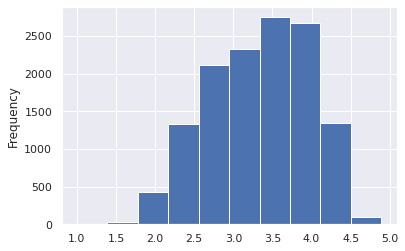

In [53]:
df_train["customer_segment"].plot(kind="hist")

In [54]:
df_train[['customer_segment', "category_level_4", 'response']].groupby(['customer_segment', "category_level_4"], as_index=False).sum().sort_values(by='response', ascending = False)

,customer_segment,category_level_4,response
10586,3.943228,3722,1.0
12392,4.268311,11343,1.0
12391,4.267700,11432,1.0
11099,4.022164,5017,1.0
1499,2.489119,43,1.0
...,...,...,...
4373,3.031580,1288,0.0
4374,3.031689,711,0.0
4375,3.031706,171,0.0
4376,3.032015,717,0.0


In [55]:
df_train[["overall_discount", 'response']].groupby(['overall_discount'], as_index=False).sum().sort_values(by='response', ascending = False)

,overall_discount,response
9252,340.825710,1.0
12062,2308.710864,1.0
12045,2258.208511,1.0
11237,953.061769,1.0
12049,2263.550086,1.0
...,...,...
4114,51.760580,0.0
4115,51.770210,0.0
4116,51.770790,0.0
4117,51.780150,0.0


In [56]:
"""df_train = df_train[df_train["overall_discount_pt"]>-3]
df_train = df_train[df_train["overall_discount_pt"]<3]"""

'df_train = df_train[df_train["overall_discount_pt"]>-3]\ndf_train = df_train[df_train["overall_discount_pt"]<3]'

In [57]:
#df_train["overall_discount_pt"].plot(kind="hist", bins = 50)

In [58]:
#df_train = outlier_treat(df_train, "overall_discount_pt")

# NEW TRAIN DATA

In [59]:
df_train = df_train[df_train["discount_total"]<500]
df_train = df_train[df_train["category_level_4"]<80000]
df_train = df_train[df_train["overall_discount"]<13900]

# OUTLIER TREATMENT

In [60]:
"""df_train.loc[df_train["overall_discount"]>=0, "discount_segment"] = 1
df_train.loc[df_train["overall_discount"]>500, "discount_segment"] = 2
df_train.loc[df_train["overall_discount"]>1000, "discount_segment"] = 3
df_train.loc[df_train["overall_discount"]>1500, "discount_segment"] = 4
df_train.loc[df_train["overall_discount"]>2000, "discount_segment"] = 5
df_train.loc[df_train["overall_discount"]>2500, "discount_segment"] = 6
df_train.loc[df_train["overall_discount"]>3000, "discount_segment"] = 7
df_train.loc[df_train["overall_discount"]>4000, "discount_segment"] = 8


df_test.loc[df_test["overall_discount"]>=0, "discount_segment"] = 1
df_test.loc[df_test["overall_discount"]>500, "discount_segment"] = 2
df_test.loc[df_test["overall_discount"]>1000, "discount_segment"] = 3
df_test.loc[df_test["overall_discount"]>1500, "discount_segment"] = 4
df_test.loc[df_test["overall_discount"]>2000, "discount_segment"] = 5
df_test.loc[df_test["overall_discount"]>2500, "discount_segment"] = 6
df_test.loc[df_test["overall_discount"]>3000, "discount_segment"] = 7
df_test.loc[df_test["overall_discount"]>4000, "discount_segment"] = 8"""

'df_train.loc[df_train["overall_discount"]>=0, "discount_segment"] = 1\ndf_train.loc[df_train["overall_discount"]>500, "discount_segment"] = 2\ndf_train.loc[df_train["overall_discount"]>1000, "discount_segment"] = 3\ndf_train.loc[df_train["overall_discount"]>1500, "discount_segment"] = 4\ndf_train.loc[df_train["overall_discount"]>2000, "discount_segment"] = 5\ndf_train.loc[df_train["overall_discount"]>2500, "discount_segment"] = 6\ndf_train.loc[df_train["overall_discount"]>3000, "discount_segment"] = 7\ndf_train.loc[df_train["overall_discount"]>4000, "discount_segment"] = 8\n\n\ndf_test.loc[df_test["overall_discount"]>=0, "discount_segment"] = 1\ndf_test.loc[df_test["overall_discount"]>500, "discount_segment"] = 2\ndf_test.loc[df_test["overall_discount"]>1000, "discount_segment"] = 3\ndf_test.loc[df_test["overall_discount"]>1500, "discount_segment"] = 4\ndf_test.loc[df_test["overall_discount"]>2000, "discount_segment"] = 5\ndf_test.loc[df_test["overall_discount"]>2500, "discount_segmen

In [61]:
"""df_train.loc[df_train["discount_per1"]>=0, "discount_1"] = 1
df_train.loc[df_train["discount_per1"]>5, "discount_1"] = 2
df_train.loc[df_train["discount_per1"]>10, "discount_1"] = 3
df_train.loc[df_train["discount_per1"]>15, "discount_1"] = 4
df_train.loc[df_train["discount_per1"]>20, "discount_1"] = 5
df_train.loc[df_train["discount_per1"]>25, "discount_1"] = 6
df_train.loc[df_train["discount_per1"]>30, "discount_1"] = 7
df_train.loc[df_train["discount_per1"]>40, "discount_1"] = 8


df_test.loc[df_test["discount_per1"]>=0, "discount_1"] = 1
df_test.loc[df_test["discount_per1"]>5, "discount_1"] = 2
df_test.loc[df_test["discount_per1"]>10, "discount_1"] = 3
df_test.loc[df_test["discount_per1"]>15, "discount_1"] = 4
df_test.loc[df_test["discount_per1"]>20, "discount_1"] = 5
df_test.loc[df_test["discount_per1"]>25, "discount_1"] = 6
df_test.loc[df_test["discount_per1"]>30, "discount_1"] = 7
df_test.loc[df_test["discount_per1"]>40, "discount_1"] = 8
"""

'df_train.loc[df_train["discount_per1"]>=0, "discount_1"] = 1\ndf_train.loc[df_train["discount_per1"]>5, "discount_1"] = 2\ndf_train.loc[df_train["discount_per1"]>10, "discount_1"] = 3\ndf_train.loc[df_train["discount_per1"]>15, "discount_1"] = 4\ndf_train.loc[df_train["discount_per1"]>20, "discount_1"] = 5\ndf_train.loc[df_train["discount_per1"]>25, "discount_1"] = 6\ndf_train.loc[df_train["discount_per1"]>30, "discount_1"] = 7\ndf_train.loc[df_train["discount_per1"]>40, "discount_1"] = 8\n\n\ndf_test.loc[df_test["discount_per1"]>=0, "discount_1"] = 1\ndf_test.loc[df_test["discount_per1"]>5, "discount_1"] = 2\ndf_test.loc[df_test["discount_per1"]>10, "discount_1"] = 3\ndf_test.loc[df_test["discount_per1"]>15, "discount_1"] = 4\ndf_test.loc[df_test["discount_per1"]>20, "discount_1"] = 5\ndf_test.loc[df_test["discount_per1"]>25, "discount_1"] = 6\ndf_test.loc[df_test["discount_per1"]>30, "discount_1"] = 7\ndf_test.loc[df_test["discount_per1"]>40, "discount_1"] = 8\n'

In [62]:
df_train.shape

(13107, 35)

In [63]:
df_train = df_train[~((df_train["response"] == 1) & (df_train["recency"] == 70))]
df_train = df_train[~((df_train["response"] == 1) & (df_train["overall_discount"] < 100) & (df_train["customer_segment"] < 4.5))]
df_train = df_train[~((df_train["response"] == 1) & (df_train["customer_segment"] < 4) & (df_train["recency"] > 9))]
df_train = df_train[~((df_train["response"] == 1) & (df_train["customer_segment"] < 3.85) & (df_train["overall_discount"] < 200))]
df_train = df_train[~((df_train["response"] == 0) & (df_train["customer_segment"]>4) & (df_train["discount_per3"]>95))]
df_train = df_train[~((df_train["response"] == 0) & (df_train["customer_segment"]>4) & (df_train["overall_discount"]>2500))]
df_train = df_train[~((df_train["response"] == 0) & (df_train["customer_segment"]>4) & (df_train["discount_per3"]>25) & (df_train["discount_per1"]>10) & (df_train["overall_discount"]>1000) & (df_train["recency"]<30))]
df_train = df_train[~((df_train["response"] == 0) & (df_train["customer_segment"]>4.5) & (df_train["overall_discount"]>1000) & (df_train["recency"]<30))]
df_train = df_train[~((df_train["response"] == 1) & (df_train["customer_segment"]<4.4) & (df_train["overall_discount"]<500) & (df_train["frequency"]<5))]
df_train = df_train[~((df_train["response"] == 1) & (df_train["customer_segment"] < 4.2) & (df_train["frequency"] < 5))]
#df_train = df_train[~((df_train["response"] == 1) & (df_train["frequency"] < 9) & (df_train["recency"] > 9))]
df_train = df_train[~((df_train["response"] == 0) & (df_train["customer_segment"]>4.4) & (df_train["recency"]<30) & (df_train["frequency"]>7) & (df_train["overall_discount"]>1000))]


In [64]:
df_ones = df_train[df_train["response"]==1]
df_zeros = df_train[df_train["response"]==0]
df_ones = df_ones[["customer_segment", "recency", "overall_discount", 
                   "M", "basketid", "discount_per1", "discount_per2",
                   "cardnumber", "frequency", "discount_per3", "odul_amt"]]
df_zeros = df_zeros[["customer_segment", "recency", "overall_discount", 
                   "M", "basketid", "discount_per1", "discount_per2",
                   "cardnumber", "frequency", "discount_per3", "odul_amt"]]
df_ones.shape

(150, 11)

In [65]:
df_zeros

,customer_segment,recency,overall_discount,M,basketid,discount_per1,discount_per2,cardnumber,frequency,discount_per3,odul_amt
8,4.165875,8,792.191402,4.248502,643,11.881192,12.326299,1,6.466145,19.382001,6.0
15,4.216991,1,577.305620,4.247195,610,2.641512,9.880751,1,6.413459,10.836544,2.0
22,2.672363,70,35.110050,3.478412,16,0.626848,0.255972,2,2.772589,0.714891,4.0
23,3.850593,8,377.831580,4.041054,166,0.834469,4.810744,2,5.111988,4.946976,6.0
42,2.950276,61,158.580360,3.626571,36,0.000137,1.121779,2,3.583519,2.850528,1.0
...,...,...,...,...,...,...,...,...,...,...,...
28567,2.705038,3,1.990040,2.828347,4,0.000008,0.000000,1,1.386294,0.200000,1.0
28569,3.039551,3,69.740090,3.243992,9,0.000052,0.000000,1,2.197225,1.901145,1.0
28571,3.050914,4,12.060090,3.283861,9,0.000020,0.181984,1,2.197225,0.249697,1.0
28572,3.034917,2,0.000100,3.184661,10,0.000014,0.000000,1,2.302585,0.000000,1.0


In [66]:
df_ones

,customer_segment,recency,overall_discount,M,basketid,discount_per1,discount_per2,cardnumber,frequency,discount_per3,odul_amt
29,4.343890,0,5151.522738,4.401479,794,73.151711,47.258075,4,6.677083,54.710598,10.0
102,4.396764,2,861.167987,4.342332,1502,7.989256,22.016372,2,7.314553,22.265738,6.0
165,4.358028,2,5125.845187,4.411965,938,108.084977,33.771795,3,6.843750,34.501918,8.0
204,4.157350,9,1729.011993,4.322229,508,37.832869,11.887630,2,6.230481,12.625687,6.0
337,4.244522,3,1519.273371,4.363265,560,36.229038,11.059896,2,6.327937,18.192780,7.0
399,4.243865,1,1336.423811,4.395303,451,9.860479,11.515754,1,6.111467,17.109491,4.0
444,4.285852,4,3020.376882,4.349288,806,37.251837,32.763633,1,6.692084,38.597666,7.0
445,4.189065,7,1139.602822,4.280178,638,15.995382,15.111638,1,6.458338,14.946863,4.0
491,4.075745,1,1680.014335,4.172197,314,33.555559,3.497111,3,5.749393,13.167984,6.0
572,4.430725,3,5416.508660,4.504912,1172,87.121268,33.589959,2,7.066467,54.552404,11.0


In [67]:
df_zeros[(df_zeros["customer_segment"]>4.4) & (df_zeros["recency"]<8) & (df_zeros["frequency"]>7) & (df_zeros["overall_discount"]>1000)]

,customer_segment,recency,overall_discount,M,basketid,discount_per1,discount_per2,cardnumber,frequency,discount_per3,odul_amt


# CHECKING THE CORRELATION AGAIN

In [68]:
df_train["try1"] = ((df_train["customer_segment"])*df_train["overall_discount"])*df_train["odul_amt"]
df_train["try2"] = ((df_train["customer_segment"])*df_train["discount_total"])*df_train["odul_amt"]
df_train["try3"] = ((df_train["customer_segment"])*df_train["discount_per1"])*df_train["odul_amt"]
df_train["try4"] = ((df_train["customer_segment"])*df_train["R"])
df_train["try5"] = ((df_train["customer_segment"])*df_train["F"])

df_test["try1"] = ((df_test["customer_segment"])*df_test["overall_discount"])*df_test["odul_amt"]
df_test["try2"] = ((df_test["customer_segment"])*df_test["discount_total"])*df_test["odul_amt"]
df_test["try3"] = ((df_test["customer_segment"])*df_test["discount_per1"])*df_test["odul_amt"]
df_test["try4"] = ((df_test["customer_segment"])*df_test["R"])
df_test["try5"] = ((df_test["customer_segment"])*df_test["F"])

In [69]:
response = df_train[["response"]]
df_train = df_train.drop(columns="response")
df_train = df_train.join(response)
corr_new = df_train.corr()
corr_new.style.background_gradient(cmap="coolwarm")

,individualnumber,recency,monetary,frequency,period,R,F,M,P,customer_segment,category_number,hakkedis_amt,odul_amt,genel_kategori,gender,age,basketid,market,is_sanal,overall_discount,discount_total,discount_per1,discount_per2,discount_per3,cardnumber,category_level_1,category_level_2,category_level_3,category_level_4,overall_discount_pt,discount_total_pt,discount_per1_pt,discount_per2_pt,discount_per3_pt,try1,try2,try3,try4,try5,response
individualnumber,1.000000,0.163377,-0.225377,-0.213497,0.035462,-0.163377,-0.213497,-0.225377,-0.107828,-0.222925,0.024202,0.070812,0.051317,-0.008848,0.050326,-0.246288,-0.200459,-0.199100,-0.057738,-0.205791,-0.178101,-0.162305,-0.230600,-0.131773,-0.180327,-0.201121,-0.196031,-0.204266,-0.204779,-0.236811,-0.240518,-0.194118,-0.240777,-0.232050,-0.127805,-0.116392,-0.114465,-0.198332,-0.231254,-0.124172
recency,0.163377,1.000000,-0.575639,-0.595886,0.132820,-1.000000,-0.595886,-0.575639,-0.382137,-0.815651,-0.001764,0.100111,0.074026,-0.000082,-0.039323,-0.090050,-0.431639,-0.423008,-0.137604,-0.327301,-0.321800,-0.221531,-0.410838,-0.283363,-0.098065,-0.424283,-0.439066,-0.434330,-0.435738,-0.556598,-0.589139,-0.445549,-0.572501,-0.572697,-0.182278,-0.189214,-0.141356,-0.978216,-0.692242,-0.110722
monetary,-0.225377,-0.575639,1.000000,0.945285,-0.317061,0.575639,0.945285,1.000000,0.614488,0.930487,-0.122138,-0.281183,-0.225684,0.057619,-0.002230,0.168991,0.700395,0.670700,0.259801,0.539675,0.506655,0.380311,0.645844,0.427474,0.151263,0.686464,0.695090,0.705791,0.707488,0.876501,0.882092,0.740875,0.851543,0.824631,0.321135,0.317370,0.254422,0.701986,0.943495,0.184065
frequency,-0.213497,-0.595886,0.945285,1.000000,-0.374579,0.595886,1.000000,0.945285,0.631370,0.942875,-0.136496,-0.340300,-0.285360,0.060640,0.039840,0.113482,0.737493,0.710787,0.262944,0.515819,0.529844,0.385458,0.672726,0.455357,0.152857,0.723364,0.740729,0.740245,0.742918,0.846534,0.914404,0.754019,0.884412,0.864679,0.295274,0.320088,0.250603,0.723130,0.982683,0.181062
period,0.035462,0.132820,-0.317061,-0.374579,1.000000,-0.132820,-0.374579,-0.317061,0.033412,-0.306200,0.006049,0.032800,0.015100,0.010636,-0.031718,0.029625,-0.279815,-0.270983,-0.096738,-0.188380,-0.195131,-0.140372,-0.253708,-0.166594,-0.046113,-0.273969,-0.282046,-0.281267,-0.282404,-0.277981,-0.346288,-0.308457,-0.351211,-0.320909,-0.103768,-0.112190,-0.086023,-0.205845,-0.366021,-0.060011
R,-0.163377,-1.000000,0.575639,0.595886,-0.132820,1.000000,0.595886,0.575639,0.382137,0.815651,0.001764,-0.100111,-0.074026,0.000082,0.039323,0.090050,0.431639,0.423008,0.137604,0.327301,0.321800,0.221531,0.410838,0.283363,0.098065,0.424283,0.439066,0.434330,0.435738,0.556598,0.589139,0.445549,0.572501,0.572697,0.182278,0.189214,0.141356,0.978216,0.692242,0.110722
F,-0.213497,-0.595886,0.945285,1.000000,-0.374579,0.595886,1.000000,0.945285,0.631370,0.942875,-0.136496,-0.340300,-0.285360,0.060640,0.039840,0.113482,0.737493,0.710787,0.262944,0.515819,0.529844,0.385458,0.672726,0.455357,0.152857,0.723364,0.740729,0.740245,0.742918,0.846534,0.914404,0.754019,0.884412,0.864679,0.295274,0.320088,0.250603,0.723130,0.982683,0.181062
M,-0.225377,-0.575639,1.000000,0.945285,-0.317061,0.575639,0.945285,1.000000,0.614488,0.930487,-0.122138,-0.281183,-0.225684,0.057619,-0.002230,0.168991,0.700395,0.670700,0.259801,0.539675,0.506655,0.380311,0.645844,0.427474,0.151263,0.686464,0.695090,0.705791,0.707488,0.876501,0.882092,0.740875,0.851543,0.824631,0.321135,0.317370,0.254422,0.701986,0.943495,0.184065
P,-0.107828,-0.382137,0.614488,0.631370,0.033412,0.382137,0.631370,0.614488,1.000000,0.603305,-0.149090,-0.316719,-0.297614,0.078119,0.014463,0.075860,0.271400,0.267793,0.082287,0.198183,0.192823,0.128310,0.253414,0.169959,0.060608,0.264784,0.276374,0.273970,0.274777,0.525710,0.528647,0.447451,0.470474,0.487812,0.100358,0.102960,0.074881,0.430350,0.572290,0.049902
customer_segment,-0.222925,-0.815651,0.930487,0.942875,-0.306200,0.815651,0.942875,0.930487,0.603305,1.000000,-0.094283,-0.2

In [70]:
#0.329491	0.346517	0.416969

In [71]:
df_test.isna().sum()

individualnumber        0
category_number         0
hakkedis_amt            0
odul_amt                0
genel_kategori          0
gender                  0
age                     0
recency                11
monetary               11
frequency              11
period                 11
R                      11
F                      11
M                      11
P                      11
customer_segment       11
basketid               11
market                 11
is_sanal               11
overall_discount       11
discount_total         11
discount_per1          11
discount_per2          11
discount_per3          11
cardnumber              0
category_level_1       11
category_level_2       11
category_level_3       11
category_level_4       11
overall_discount_pt    11
discount_total_pt      11
discount_per1_pt       11
discount_per2_pt       11
discount_per3_pt       11
try1                   11
try2                   11
try3                   11
try4                   11
try5        

# DUMMIES

In [72]:
"""df_train = pd.get_dummies(df_train, columns = ["genel_kategori", "age", "category_number"], drop_first = True)
df_test = pd.get_dummies(df_test, columns = ["genel_kategori", "age", "category_number"], drop_first = True)"""

'df_train = pd.get_dummies(df_train, columns = ["genel_kategori", "age", "category_number"], drop_first = True)\ndf_test = pd.get_dummies(df_test, columns = ["genel_kategori", "age", "category_number"], drop_first = True)'

In [73]:
for col in df_test.columns:
    df_test[col].fillna(df_test[col].median(), inplace=True)

In [74]:
df_train['category_level_1'] = df_train['category_level_1'].fillna(df_train['category_level_1'].median())
df_train['category_level_2'] = df_train['category_level_2'].fillna(df_train['category_level_2'].median())
df_train['category_level_3'] = df_train['category_level_3'].fillna(df_train['category_level_3'].median())
df_train['category_level_4'] = df_train['category_level_4'].fillna(df_train['category_level_4'].median())

In [75]:
df_test['category_level_1'] = df_test['category_level_1'].fillna(df_test['category_level_1'].median())
df_test['category_level_2'] = df_test['category_level_2'].fillna(df_test['category_level_2'].median())
df_test['category_level_3'] = df_test['category_level_3'].fillna(df_test['category_level_3'].median())
df_test['category_level_4'] = df_test['category_level_4'].fillna(df_test['category_level_4'].median())

In [76]:
df_train["category_total"] = df_train['category_level_1']+df_train['category_level_2']+df_train['category_level_3']+df_train['category_level_4']
df_test["category_total"] = df_test['category_level_1']+df_test['category_level_2']+df_test['category_level_3']+df_test['category_level_4']

In [77]:
corr_new = df_train.corr()
corr_new.style.background_gradient(cmap="coolwarm")

,individualnumber,recency,monetary,frequency,period,R,F,M,P,customer_segment,category_number,hakkedis_amt,odul_amt,genel_kategori,gender,age,basketid,market,is_sanal,overall_discount,discount_total,discount_per1,discount_per2,discount_per3,cardnumber,category_level_1,category_level_2,category_level_3,category_level_4,overall_discount_pt,discount_total_pt,discount_per1_pt,discount_per2_pt,discount_per3_pt,try1,try2,try3,try4,try5,response,category_total
individualnumber,1.000000,0.163377,-0.225377,-0.213497,0.035462,-0.163377,-0.213497,-0.225377,-0.107828,-0.222925,0.024202,0.070812,0.051317,-0.008848,0.050326,-0.246288,-0.200459,-0.199100,-0.057738,-0.205791,-0.178101,-0.162305,-0.230600,-0.131773,-0.180327,-0.201121,-0.196031,-0.204266,-0.204779,-0.236811,-0.240518,-0.194118,-0.240777,-0.232050,-0.127805,-0.116392,-0.114465,-0.198332,-0.231254,-0.124172,-0.201767
recency,0.163377,1.000000,-0.575639,-0.595886,0.132820,-1.000000,-0.595886,-0.575639,-0.382137,-0.815651,-0.001764,0.100111,0.074026,-0.000082,-0.039323,-0.090050,-0.431639,-0.423008,-0.137604,-0.327301,-0.321800,-0.221531,-0.410838,-0.283363,-0.098065,-0.424283,-0.439066,-0.434330,-0.435738,-0.556598,-0.589139,-0.445549,-0.572501,-0.572697,-0.182278,-0.189214,-0.141356,-0.978216,-0.692242,-0.110722,-0.428344
monetary,-0.225377,-0.575639,1.000000,0.945285,-0.317061,0.575639,0.945285,1.000000,0.614488,0.930487,-0.122138,-0.281183,-0.225684,0.057619,-0.002230,0.168991,0.700395,0.670700,0.259801,0.539675,0.506655,0.380311,0.645844,0.427474,0.151263,0.686464,0.695090,0.705791,0.707488,0.876501,0.882092,0.740875,0.851543,0.824631,0.321135,0.317370,0.254422,0.701986,0.943495,0.184065,0.691904
frequency,-0.213497,-0.595886,0.945285,1.000000,-0.374579,0.595886,1.000000,0.945285,0.631370,0.942875,-0.136496,-0.340300,-0.285360,0.060640,0.039840,0.113482,0.737493,0.710787,0.262944,0.515819,0.529844,0.385458,0.672726,0.455357,0.152857,0.723364,0.740729,0.740245,0.742918,0.846534,0.914404,0.754019,0.884412,0.864679,0.295274,0.320088,0.250603,0.723130,0.982683,0.181062,0.729557
period,0.035462,0.132820,-0.317061,-0.374579,1.000000,-0.132820,-0.374579,-0.317061,0.033412,-0.306200,0.006049,0.032800,0.015100,0.010636,-0.031718,0.029625,-0.279815,-0.270983,-0.096738,-0.188380,-0.195131,-0.140372,-0.253708,-0.166594,-0.046113,-0.273969,-0.282046,-0.281267,-0.282404,-0.277981,-0.346288,-0.308457,-0.351211,-0.320909,-0.103768,-0.112190,-0.086023,-0.205845,-0.366021,-0.060011,-0.276548
R,-0.163377,-1.000000,0.575639,0.595886,-0.132820,1.000000,0.595886,0.575639,0.382137,0.815651,0.001764,-0.100111,-0.074026,0.000082,0.039323,0.090050,0.431639,0.423008,0.137604,0.327301,0.321800,0.221531,0.410838,0.283363,0.098065,0.424283,0.439066,0.434330,0.435738,0.556598,0.589139,0.445549,0.572501,0.572697,0.182278,0.189214,0.141356,0.978216,0.692242,0.110722,0.428344
F,-0.213497,-0.595886,0.945285,1.000000,-0.374579,0.595886,1.000000,0.945285,0.631370,0.942875,-0.136496,-0.340300,-0.285360,0.060640,0.039840,0.113482,0.737493,0.710787,0.262944,0.515819,0.529844,0.385458,0.672726,0.455357,0.152857,0.723364,0.740729,0.740245,0.742918,0.846534,0.914404,0.754019,0.884412,0.864679,0.295274,0.320088,0.250603,0.723130,0.982683,0.181062,0.729557
M,-0.225377,-0.575639,1.000000,0.945285,-0.317061,0.575639,0.945285,1.000000,0.614488,0.930487,-0.122138,-0.281183,-0.225684,0.057619,-0.002230,0.168991,0.700395,0.670700,0.259801,0.539675,0.506655,0.380311,0.645844,0.427474,0.151263,0.686464,0.695090,0.705791,0.707488,0.876501,0.882092,0.740875,0.851543,0.824631,0.321135,0.317370,0.254422,0.701986,0.943495,0.184065,0.691904
P,-0.107828,-0.382137,0.614488,0.631370,0.033412,0.382137,0.631370,0.614488,1.000000,0.603305,-0.149090,-0.316719,-0.297614,0.078119,0.014463,0.075860,0.271400,0.267793,0.082287,0.198183,0.192823,0.128310,0.253414,0.169959,0.060608,0.264784,0.276374,0.273970,0.274777,0.525710,0.528647,0.447451,0.470474,0.487812,0.100358,0.102960,0.074881,0.430350,0.572290,0.049902,0.267820
customer_segment,-0.22292

In [78]:
df_train = df_train.sample(frac = 1)

# BUILDING X AND Y

In [79]:
"""X = df_new[['customer_segment', "hakkedis_amt", "odul_amt", "overall_discount", "overall_discount_pt"]]
y = df_new['response']
df_test = df_test[['customer_segment', "hakkedis_amt", "odul_amt", "overall_discount", "overall_discount_pt"]]
X.shape"""

'X = df_new[[\'customer_segment\', "hakkedis_amt", "odul_amt", "overall_discount", "overall_discount_pt"]]\ny = df_new[\'response\']\ndf_test = df_test[[\'customer_segment\', "hakkedis_amt", "odul_amt", "overall_discount", "overall_discount_pt"]]\nX.shape'

In [80]:
df_test["genel_kategori"] = df_test["genel_kategori"].astype(float)

In [81]:
train_cols = list(df_test.columns)
remove = ["try2", "try1", "try3", "discount_total", "category_level_1",
          "category_level_2", "category_level_3", "R", "F", "try4", "try5",
           "category_level_4", "market", "monetary", "category_total",
          "discount_total_pt", "discount_per1_pt", "discount_per2_pt", "discount_per3_pt",
          "overall_discount_pt", "hakkedis_amt"]
train_cols = list(set(train_cols) - set(remove))

In [82]:
X = df_train[train_cols]
y = df_train['response']
df_test = df_test[train_cols]
X

,frequency,gender,overall_discount,genel_kategori,is_sanal,category_number,period,discount_per2,odul_amt,basketid,discount_per3,P,discount_per1,recency,age,individualnumber,customer_segment,cardnumber,M
16006,1.945910,0.0,5.98007,3.0,0,0.0,0.000000,0.000000,1.0,7,0.200000,1.000000,0.000044,70,4.0,96850875,2.491044,1,3.374075
18654,3.951244,1.0,57.28052,2.0,0,20.0,5.519231,1.440153,2.0,52,2.982702,4.850326,0.000060,30,5.0,98045557,3.269215,1,3.618123
18906,4.343805,0.0,47.94077,1.0,0,31.0,4.233766,1.283509,5.0,77,0.923764,4.885186,0.000239,9,6.0,98151672,3.560248,1,3.717530
16433,1.386294,0.0,20.35004,3.0,0,6.0,0.000000,0.606349,3.0,4,0.000000,1.000000,0.000003,70,6.0,97047613,2.250346,1,3.067534
27701,2.639057,0.0,19.36014,1.0,0,12.0,0.000000,0.296242,5.0,14,0.500818,1.000000,0.000027,59,4.0,101902696,2.657785,1,3.302407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26678,5.379897,1.0,473.25117,3.0,0,0.0,0.995392,5.725369,1.0,217,3.039444,4.973006,11.081061,8,6.0,101508746,3.912521,1,4.081199
21423,3.091042,0.0,33.64011,2.0,0,20.0,10.272727,0.195751,2.0,22,0.549841,4.721418,1.186588,70,5.0,99294077,2.724867,1,3.483917
20419,2.833213,1.0,70.16017,2.0,0,46.0,10.470588,0.000000,2.0,17,2.500130,4.716052,0.000011,70,6.0,98826172,2.671946,1,3.458635
17524,4.248495,0.0,9.24070,3.0,0,6.0,4.514286,0.326511,3.0,70,0.896904,4.877579,0.000122,11,1.0,97527732,3.481006,1,3.623112


In [83]:
X = pd.get_dummies(X, columns = ["genel_kategori", "age"], drop_first = True)
df_test = pd.get_dummies(df_test, columns = ["genel_kategori", "age"], drop_first = True)

In [84]:
df_submission = df_test

In [85]:
cols = list(X.columns)

In [86]:
scaler = RobustScaler()
X = scaler.fit_transform(X)
df_test = scaler.fit_transform(df_test)

In [87]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import cv
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.10, random_state = 10)

In [88]:
from sklearn import model_selection
"""model = IsolationForest(random_state=47)

param_grid = {'n_estimators': [1000, 1500], 
              'max_samples': [10], 
              'contamination': ['auto', 0.0001, 0.0002], 
              'max_features': [10, 15], 
              'bootstrap': [True], 
              'n_jobs': [-1]}

grid_search = model_selection.GridSearchCV(model, 
                                           param_grid,
                                           scoring="f1", 
                                           refit=True,
                                           cv=10, 
                                           return_train_score=True)
grid_search.fit(X, y)

best_model = grid_search.fit(X, y)
print('Optimum parameters', best_model.best_params_)"""

'model = IsolationForest(random_state=47)\n\nparam_grid = {\'n_estimators\': [1000, 1500], \n              \'max_samples\': [10], \n              \'contamination\': [\'auto\', 0.0001, 0.0002], \n              \'max_features\': [10, 15], \n              \'bootstrap\': [True], \n              \'n_jobs\': [-1]}\n\ngrid_search = model_selection.GridSearchCV(model, \n                                           param_grid,\n                                           scoring="f1", \n                                           refit=True,\n                                           cv=10, \n                                           return_train_score=True)\ngrid_search.fit(X, y)\n\nbest_model = grid_search.fit(X, y)\nprint(\'Optimum parameters\', best_model.best_params_)'

In [89]:
"""iforest = IsolationForest(bootstrap=True,
                          contamination=0.1, 
                          max_features=15, 
                          max_samples="auto", 
                          n_estimators=100, 
                          n_jobs=-1,
                         random_state=1)
y_pred = iforest.fit_predict(X)
X, y = X[(y_pred != -1), :], y[(y_pred != -1)]
X.shape"""

'iforest = IsolationForest(bootstrap=True,\n                          contamination=0.1, \n                          max_features=15, \n                          max_samples="auto", \n                          n_estimators=100, \n                          n_jobs=-1,\n                         random_state=1)\ny_pred = iforest.fit_predict(X)\nX, y = X[(y_pred != -1), :], y[(y_pred != -1)]\nX.shape'

# DIFFERENT MODELS FOR PREDICTION

In [90]:
"""rng = np.random.RandomState(42)

model = IsolationForest(n_estimators = 6000,
                        contamination = 0.02,
                        random_state=rng)"""

'rng = np.random.RandomState(42)\n\nmodel = IsolationForest(n_estimators = 6000,\n                        contamination = 0.02,\n                        random_state=rng)'

# FITTING THE DATA

In [91]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [92]:
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

In [93]:
from numpy import mean
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from sklearn.datasets import make_gaussian_quantiles

"""X, y = make_gaussian_quantiles(cov=3.,
                                 n_samples=12000, n_features=X.shape[1],
                                 n_classes=2, random_state=1)"""

"""X, y = make_classification(n_samples=12000, n_features=X.shape[1], n_redundant=0, n_repeated=0,
                    n_classes=2, n_clusters_per_class=2, class_sep=1.75, flip_y=0,
                    weights=[0.98, 0.02], random_state=93)"""

"""X, y = make_classification(n_samples = 12000, n_features=X.shape[1], n_redundant=2,
                           random_state=93)"""

"""oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(X, y)"""

"""oversample = SVMSMOTE()
X, y = oversample.fit_resample(X, y)"""

'oversample = SVMSMOTE()\nX, y = oversample.fit_resample(X, y)'

In [94]:
"""k_values = [2, 3, 4, 5, 6, 7]

for k in k_values: 
    model = xgb.XGBClassifier(n_estimators = 400,
                              # scale_pos_weight=98,
                               learning_rate = 0.1,
                               objective = 'binary:logistic',
                               eval_metric = 'auc',
                               min_split_loss = 0.02,
                               max_depth = 4,
                               reg_alpha = 20,
                               reg_lambda = 0.8,
                               subsample = 0.8,
                               min_child_weight = 1,
                               colsample_bytree = 0.8,
                               gamma = 0.1,
                               scale_pos_weight = 1,
                               random_state = 50)

    over = SVMSMOTE(sampling_strategy=0.02, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.1)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean F1: %.3f' % (k, score))"""

"k_values = [2, 3, 4, 5, 6, 7]\n\nfor k in k_values: \n    model = xgb.XGBClassifier(n_estimators = 400,\n                              # scale_pos_weight=98,\n                               learning_rate = 0.1,\n                               objective = 'binary:logistic',\n                               eval_metric = 'auc',\n                               min_split_loss = 0.02,\n                               max_depth = 4,\n                               reg_alpha = 20,\n                               reg_lambda = 0.8,\n                               subsample = 0.8,\n                               min_child_weight = 1,\n                               colsample_bytree = 0.8,\n                               gamma = 0.1,\n                               scale_pos_weight = 1,\n                               random_state = 50)\n\n    over = SVMSMOTE(sampling_strategy=0.02, k_neighbors=k)\n    under = RandomUnderSampler(sampling_strategy=0.1)\n    steps = [('over', over), ('under', under)

In [95]:
"""param_test1 = {
    'n_estimators':range(200,1100,100),
    'learning_rate':[0.03, 0.06, 0.1, 0.3],
    'reg_alpha':[10, 20, 40, 60],
    'reg_lambda':[0.6, 0.8, 1, 2, 4]

}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                            n_estimators = 1000,
                            #scale_pos_weight=98,
                            learning_rate = 0.1,
                            objective = 'binary:logistic',
                            min_split_loss = 0.02,
                            max_depth = 4,
                            reg_alpha = 20,
                            reg_lambda = 0.8,
                            subsample = 0.8,
                            min_child_weight = 1,
                            scale_pos_weight = 1,
                            colsample_bytree = 0.8,
                            gamma = 0.2,
                            random_state = 50), 
param_grid = param_test1, scoring='f1',n_jobs=4, cv=5)
gsearch1.fit(X, y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_"""

"param_test1 = {\n    'n_estimators':range(200,1100,100),\n    'learning_rate':[0.03, 0.06, 0.1, 0.3],\n    'reg_alpha':[10, 20, 40, 60],\n    'reg_lambda':[0.6, 0.8, 1, 2, 4]\n\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(\n                            n_estimators = 1000,\n                            #scale_pos_weight=98,\n                            learning_rate = 0.1,\n                            objective = 'binary:logistic',\n                            min_split_loss = 0.02,\n                            max_depth = 4,\n                            reg_alpha = 20,\n                            reg_lambda = 0.8,\n                            subsample = 0.8,\n                            min_child_weight = 1,\n                            scale_pos_weight = 1,\n                            colsample_bytree = 0.8,\n                            gamma = 0.2,\n                            random_state = 50), \nparam_grid = param_test1, scoring='f1',n_jobs=4, cv=5)\ngsearch1.fit(X

Counter({0.0: 12472, 1.0: 150})
> k=5, Mean F1: 0.638
Counter({0.0: 12472, 1.0: 150})


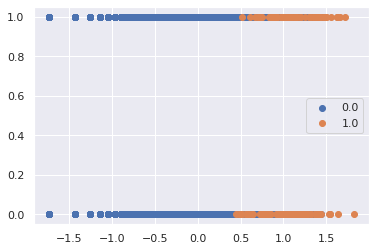

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              min_split_loss=0.02, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=50, reg_alpha=4, ...)

In [96]:


model = xgb.XGBClassifier(n_estimators = 10000,
                            #scale_pos_weight=98,
                            learning_rate = 0.1,
                            objective = 'binary:logistic',
                            min_split_loss = 0.02,
                            max_depth = 4,
                            reg_alpha = 4,
                            reg_lambda = 0.8,
                            subsample = 0.85,
                            min_child_weight = 1,
                            colsample_bytree = 0.8,
                            gamma = 0.2,
                            random_state = 50)

counter = Counter(y)
print(counter)
over = SVMSMOTE(sampling_strategy=0.03, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.15)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
score = mean(scores)
print('> k=%d, Mean F1: %.3f' % (5, score))
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

model.fit(X, y, eval_metric=f1_eval)

In [97]:
"""# fit the model
model.fit(X_train, y_train)
predict_train = model.predict(X_train)#.decision_function(X_train)
predict_test = model.predict(X_test)#.decision_function(X_test)
#y_pred_outliers = model.predict(X_outliers)
predict_train"""

'# fit the model\nmodel.fit(X_train, y_train)\npredict_train = model.predict(X_train)#.decision_function(X_train)\npredict_test = model.predict(X_test)#.decision_function(X_test)\n#y_pred_outliers = model.predict(X_outliers)\npredict_train'

In [98]:
"""predict_train = pd.DataFrame({"pred":predict_train})
predict_test = pd.DataFrame({"pred":predict_test})"""

'predict_train = pd.DataFrame({"pred":predict_train})\npredict_test = pd.DataFrame({"pred":predict_test})'

In [99]:
"""predict_train[predict_train["pred"]==1]=0
predict_test[predict_test["pred"]==1]=0
predict_train[predict_train["pred"]==-1]=1
predict_test[predict_test["pred"]==-1]=1
predict_train = np.array(predict_train.pred)
predict_test = np.array(predict_test.pred)"""

'predict_train[predict_train["pred"]==1]=0\npredict_test[predict_test["pred"]==1]=0\npredict_train[predict_train["pred"]==-1]=1\npredict_test[predict_test["pred"]==-1]=1\npredict_train = np.array(predict_train.pred)\npredict_test = np.array(predict_test.pred)'

In [100]:
"""print("accuracy is %", round(accuracy_score(predict_train, y_train), 2)*100)
print("precision is %", round(precision_score(predict_train, y_train), 2)*100)
print("recall is %", round(recall_score(predict_train, y_train), 2)*100)
print("f1 is %", round(f1_score(predict_train, y_train), 2)*100)"""

'print("accuracy is %", round(accuracy_score(predict_train, y_train), 2)*100)\nprint("precision is %", round(precision_score(predict_train, y_train), 2)*100)\nprint("recall is %", round(recall_score(predict_train, y_train), 2)*100)\nprint("f1 is %", round(f1_score(predict_train, y_train), 2)*100)'

In [101]:
"""print("accuracy is %", round(accuracy_score(predict_test, y_test), 2)*100)
print("precision is %", round(precision_score(predict_test, y_test), 2)*100)
print("recall is %", round(recall_score(predict_test, y_test), 2)*100)
print("f1 is %", round(f1_score(predict_test, y_test), 2)*100)"""

'print("accuracy is %", round(accuracy_score(predict_test, y_test), 2)*100)\nprint("precision is %", round(precision_score(predict_test, y_test), 2)*100)\nprint("recall is %", round(recall_score(predict_test, y_test), 2)*100)\nprint("f1 is %", round(f1_score(predict_test, y_test), 2)*100)'

# PREDICTING THE TEST DATA


In [102]:
df_test.shape

(13236, 26)

In [103]:
pred = model.predict(df_test)
"""pred = pd.DataFrame({"pred":pred})
pred[pred["pred"]==1]=0
pred[pred["pred"]==-1]=1
pred = np.array(pred.pred)"""

'pred = pd.DataFrame({"pred":pred})\npred[pred["pred"]==1]=0\npred[pred["pred"]==-1]=1\npred = np.array(pred.pred)'

In [104]:
df_sub = pd.DataFrame({"individualnumber":ID, "response":pred})
df_sub

,individualnumber,response
0,95812936,0
1,23929570,0
2,95948115,0
3,100898513,0
4,12769156,1
...,...,...
13231,93418529,0
13232,97397069,0
13233,95212479,0
13234,93406449,0


In [105]:
df_sub.response.value_counts()

0    12960
1      276
Name: response, dtype: int64

In [106]:
df_sub.to_csv("submission.csv", index=False)

In [107]:
#df_submission = pd.DataFrame(data = df_test, columns = cols)
df_submission["response"] = df_sub["response"]
df_submission

,frequency,gender,overall_discount,is_sanal,category_number,period,discount_per2,odul_amt,basketid,discount_per3,...,genel_kategori_1.0,genel_kategori_2.0,genel_kategori_3.0,genel_kategori_4.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,response
0,3.332205,0,42.320250,0.0,23,2.714286,0.000000,3.0,28.0,1.000000,...,0,0,0,1,1,0,0,0,0,0
1,3.806662,0,278.414944,0.0,12,7.488889,3.633957,2.0,45.0,3.333489,...,1,0,0,0,0,0,1,0,0,0
2,3.091042,0,83.010059,0.0,16,4.409091,0.306449,2.0,22.0,0.556295,...,1,0,0,0,0,0,0,1,0,0
3,5.545177,1,662.631627,0.0,27,0.902344,3.122626,4.0,256.0,7.977817,...,1,0,0,0,0,0,1,0,0,0
4,7.357556,1,3837.964730,261.0,13,0.232143,40.208836,3.0,1568.0,45.540167,...,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,5.509388,0,609.622370,0.0,39,1.388664,7.782953,3.0,247.0,19.948805,...,0,0,0,0,0,0,1,0,0,0
13232,3.258097,0,4.810260,0.0,15,11.461538,0.281914,2.0,26.0,0.249729,...,1,0,0,0,1,0,0,0,0,0
13233,2.708050,0,86.910150,0.0,37,20.933333,0.205075,8.0,15.0,2.650651,...,1,0,0,0,0,0,0,0,1,0
13234,4.204693,0,214.460509,0.0,26,4.716418,1.131882,3.0,67.0,4.734435,...,0,0,0,1,0,0,0,1,0,0


In [108]:
test_ones = df_submission[df_submission["response"]==1]
test_zeros = df_submission[df_submission["response"]==0]
test_ones = test_ones[["customer_segment", "recency", "overall_discount", 
                   "M", "basketid", "discount_per1", "discount_per2",
                   "cardnumber", "frequency"]]
test_zeros = test_zeros[["customer_segment", "recency", "overall_discount", 
                   "M", "basketid", "discount_per1", "discount_per2",
                   "cardnumber", "frequency"]]
test_ones.shape

(276, 9)

In [109]:
test_zeros[(test_zeros["customer_segment"]>4.3) & (test_zeros["overall_discount"]>5) & (test_zeros["frequency"]>6.5) ]

,customer_segment,recency,overall_discount,M,basketid,discount_per1,discount_per2,cardnumber,frequency
6,4.499179,3.0,1249.761855,4.551267,1566.0,7.820477,19.409006,1,7.356280
245,4.412349,1.0,1081.517636,4.449173,1116.0,13.116500,12.275957,1,7.017506
287,4.340010,12.0,1314.778721,4.498148,1098.0,9.534242,12.912569,1,7.001246
411,4.558936,2.0,651.926212,4.563750,2088.0,4.428957,10.590802,1,7.643962
416,4.313915,4.0,1670.902733,4.348512,967.0,34.393824,24.979486,2,6.874198
...,...,...,...,...,...,...,...,...,...
13005,4.502755,1.0,2251.443898,4.516058,1607.0,15.904796,29.616446,1,7.382124
13070,4.418250,0.0,1959.998441,4.456401,1072.0,15.268707,18.194805,1,6.977281
13127,4.355607,0.0,1044.491617,4.325339,1092.0,7.048692,11.082168,2,6.995766
13133,4.335087,9.0,2274.006082,4.447877,1060.0,14.461641,23.012720,2,6.966024


In [110]:
test_ones[(test_ones["customer_segment"]<4.5)]

,customer_segment,recency,overall_discount,M,basketid,discount_per1,discount_per2,cardnumber,frequency
312,4.321979,0.0,2464.117770,4.331258,864.0,42.042818,34.510162,1,6.761573
406,4.494659,0.0,2787.982472,4.502798,1507.0,19.688289,31.449950,1,7.317876
564,4.461898,3.0,5892.302547,4.507945,1417.0,98.870527,56.284815,3,7.256297
637,4.162191,25.0,4472.015443,4.408638,956.0,49.299711,31.093120,2,6.862758
756,4.295568,0.0,4200.368782,4.338458,713.0,74.982808,21.050491,2,6.569481
845,4.322238,0.0,2813.385511,4.352328,809.0,47.703641,28.398595,1,6.695799
847,4.268226,1.0,2071.333836,4.302232,710.0,22.036107,19.489675,1,6.565265
905,4.242342,0.0,2139.311866,4.209193,767.0,41.055809,17.192670,2,6.642487
994,4.272187,1.0,2822.297490,4.324105,679.0,41.833567,22.885486,1,6.520621
1069,4.480126,1.0,3134.471153,4.531563,1323.0,14.191297,33.741272,1,7.187657


In [111]:
len(test_zeros[(test_zeros["customer_segment"]>4.5) & (test_zeros["overall_discount"]>2000) & (test_zeros["frequency"]>6.5) ])

11

In [112]:
len(test_zeros[(test_zeros["customer_segment"]>4.5) & (test_zeros["overall_discount"]>2000) & (test_zeros["recency"]<8) ])

11

In [113]:
len(test_ones[(test_ones["customer_segment"]<4.4) & (test_ones["overall_discount"]<2000)])

11

In [114]:
len(test_ones[(test_ones["customer_segment"]<4.4) & (test_ones["frequency"]<7)])

104

In [115]:
len(test_ones[(test_ones["customer_segment"]<4.4) & (test_ones["basketid"]<1000)])

100